# Part 1 : Topic detection analyse
---
In this part of the document, we will analyse the topics that we can identify in our filtered quotes on climate change. We will uses the datasets generated during the project `phase 2` initial analysis. The goal is to generate some word clouds with the most used words in our quotes for every month of all our years.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
path_to_out_2015 = '/content/drive/MyDrive/quotes-2015-filtered.json.bz2'
path_to_out_2016 = '/content/drive/MyDrive/quotes-2016-filtered.json.bz2'
path_to_out_2017 = '/content/drive/MyDrive/quotes-2017-filtered.json.bz2'
path_to_out_2018 = '/content/drive/MyDrive/quotes-2018-filtered.json.bz2'
path_to_out_2019 = '/content/drive/MyDrive/quotes-2019-filtered.json.bz2'
path_to_out_2020 = '/content/drive/MyDrive/quotes-2020-filtered.json.bz2'
data_2015 = pd.read_json(path_to_out_2015, lines=True)
data_2016 = pd.read_json(path_to_out_2016, lines=True)
data_2017 = pd.read_json(path_to_out_2017, lines=True)
data_2018 = pd.read_json(path_to_out_2018, lines=True)
data_2019 = pd.read_json(path_to_out_2019, lines=True)
data_2020 = pd.read_json(path_to_out_2020, lines=True)

In [ ]:
data = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020]
data_all_years = pd.concat(data)

## Filtering

In [ ]:
# Filter out identified invalid quotes 
set_filter = ['{commentID}', 'displayNone', 'border: 2px solid #ccc', 'overflow:', 'display:']
data_all_removed = data_all_years[data_all_years.quotation.str.contains('|'.join(set_filter))]
data_all = data_all_years[np.logical_not(data_all_years.quotation.str.contains('|'.join(set_filter)))].copy()

During our analysis, we identified a number of invalid quotes. Those one came out in sight while doing some statistiques on `numOccurences`.  A few quotes had this property field with a very high value. And this was very surprising. So after having identified this issue we developped this filter to remove all those `invalid` quotes.

## Histogram of the quotes
To have an idea of the distributions of the quotes through the years we worked on, we decided to generate an histogram of the quotations. We take into account the property `numOccurences` as it indicates weither a given quotation was used more than once and was influencing the histogram.

In [ ]:
# Group data by month 
data_all['date'] = data_all['date'].map(lambda x:str(x)[0:7])
quotes = data_all[['numOccurrences','date']]
quotes = quotes.groupby(['date'],as_index=False).sum()

In [ ]:
# Generate histogram of quotes by month
import plotly.graph_objects as go

fig = go.Figure(data=[go.Bar(
    x=quotes.date,
    y=quotes.numOccurrences)])
fig.update_layout(xaxis_tickangle=-45)
fig.write_html('/content/drive/MyDrive/histogram_quotes.html')

fig.show()

The first version of the histogram had a strange peak at **825k**. After digging up we identified that it was a fake quotation linked with the initial parsing of the data. This issue allowed to to update our filters. 

## Preparing the data
The first task was to prepare the data by pre-calculating a column by month and by year to ease the use. 

In [ ]:
# Compute 2 additional columns 'year' and 'month'
data_all['year'] = data_all['date'].map(lambda x:str(x)[0:4])
data_all['month'] = data_all['date'].map(lambda x:str(x)[5:7])
quotes_year_month = data_all[['quotation','numOccurrences', 'year', 'month']]

In [ ]:
# Group by year and month
quotes_by_year = quotes_year_month.groupby(quotes_year_month.year)
quotes_by_month = [quotes_by_year.get_group(year).groupby(quotes_by_year.get_group(year).month) for year in quotes_by_year.groups.keys()]

## Language processing
The next step was to process quotes by using nlp and removing all stop words. 

In [ ]:
import spacy, nltk, gensim, sklearn
# Select english language
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Process nlp on all quotes
def nlp_process(data):
  quotes=[]
  quotes_array = np.array(data['quotation'])
  for q in range(len(quotes_array)):
    quote_nlp = nlp(quotes_array[q])
    quotes.append(quote_nlp)  
  return quotes

quotes_nlp = np.empty(len(quotes_by_year.groups.keys()), dtype=object)
for i,year in enumerate(quotes_by_year.groups.keys()):
  quotes_nlp[i] = [nlp_process(quotes_by_month[i].get_group(month)) for month in quotes_by_month[i].groups.keys()]
  

In [ ]:
# Lemmatization of words per month
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
climate_set = {'climate', 'change', 'global', 'warming'}
stop_words = set.union(en_stop, climate_set )
def token_process(data):
  tokens=[]
  for q in data:
    # Lemmatize tokens, remove punctuation, numbers and stopwords
    token_res = [token for token in q if token.is_alpha and not token.is_stop ]
    # Remove common words from a stopword list and keep only words of length 4 or more.
    token_res = [token.lemma_ for token in token_res if token not in stop_words and len(token) > 3]
    tokens.append(token_res)
  return tokens

words_month = np.empty(len(quotes_by_year.groups.keys()), dtype=object)
for i,year in enumerate(quotes_by_year.groups.keys()):
  words_month[i] = [token_process(quotes) for quotes in quotes_nlp[i]]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Word Model processing
The next step is to train a model for each month in the goel of identifying the main topics. using `Gensim` we generated a single set of topics per month.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

In [ ]:
# Process one model per month for every year
seed = 42
params = {'passes': 10, 'random_state': seed}

def model_process(quotes):
  dictionary = Dictionary(quotes)
  base_models = dict()
  corpus = [dictionary.doc2bow(quote) for quote in quotes]
  model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])
  return model

models = np.empty(len(quotes_by_year.groups.keys()), dtype=object)
for i,year in enumerate(quotes_by_year.groups.keys()):
  models[i] = [model_process(quotes) for quotes in words_month[i]]


In [ ]:
# Generate the topics for each model
topics = [m.show_topic(1,20) for m in models[0]]

We haven't calculated any accuracy score for our models because it was not needed in our analysis, we wanted to see if some specific words in the top words where allowing us to identify some events.  

## Word cloud generation
This last step consist in generating the word clouds for each month. To do so, we used `wordcloud`. 

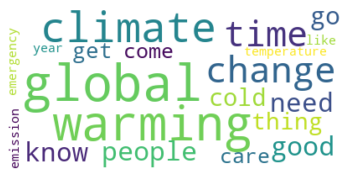

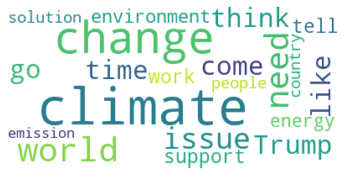

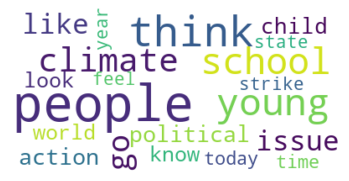

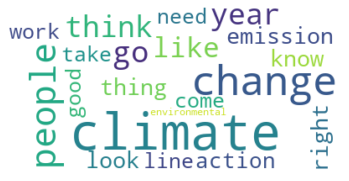

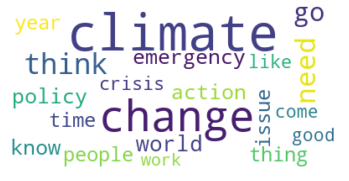

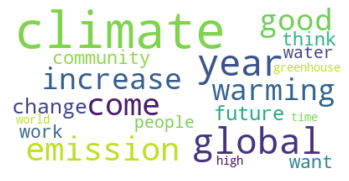

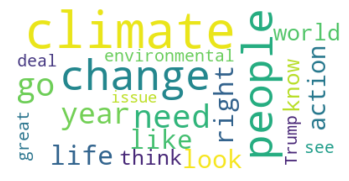

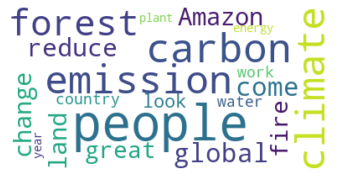

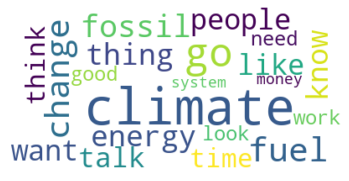

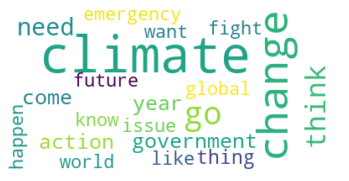

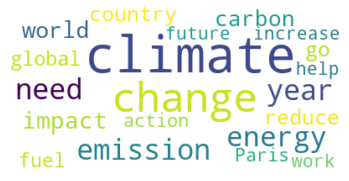

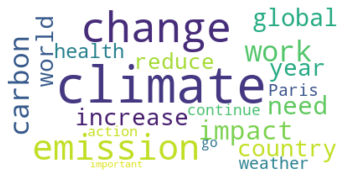

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

# Generate word clouds
def wordcloud_process(text,i):
  wordcloud = WordCloud(background_color="white",mask=None, max_words=100, max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
  contour_width=3,contour_color='black').fit_words(dict(text))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.savefig("/content/drive/MyDrive/topic2019#"+str(i)+'.png', format="png")
  plt.show()

wordclouds = [wordcloud_process(topic,i) for i,topic in enumerate(topics)]